# Hotel Booking Prediction

## Load Libraries

In [5]:
# Load built-in libraries
import requests
import pickle
import joblib

# Load data manipulation libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Set model SEED for consistent results
SEED = 123 

## Get Booking Data

In [7]:
# Fetch dataset from API
url = "http://localhost:8000/hotel_booking"  # Replace with your API endpoint

headers = {
    "Accept": "application/json"
}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # If the response contains an HTTP error status code, this will raise a HTTPError  
    data = response.json()  # Parse the JSON data from the response
    print("Success! Data loaded.")
except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except requests.exceptions.RequestException as err:
    print(f"Error occurred: {err}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Success! Data loaded.


In [8]:
# Load data onto Pandas DataFrame
df = pd.DataFrame(data, columns=['age','destination','first_browser','language','booking'])
print('[INFO] Booking data loaded onto DataFrame...')
print('')
df.info()

[INFO] Booking data loaded onto DataFrame...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1714 non-null   float64
 1   destination    3000 non-null   object 
 2   first_browser  3000 non-null   object 
 3   language       3000 non-null   object 
 4   booking        3000 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 117.3+ KB


In [9]:
df['customer_id'] = 1
df['customer_id'] = df['customer_id'].cumsum(); df.head()

,age,destination,first_browser,language,booking,customer_id
0,NaN,NDF,IE,en,1,1
1,28.0,NDF,Chrome,en,1,2
2,NaN,GB,-unknown-,en,1,3
3,32.0,NDF,Safari,en,1,4
4,NaN,NDF,IE,en,1,5


In [10]:
def random_dates(start, end, n=10):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

start = pd.to_datetime('2021-01-01')
end = pd.to_datetime('2022-04-01')
df['session_date'] = random_dates(start, end, df.shape[0])

In [11]:
df[['customer_id','session_date','age','destination','first_browser','language','booking']].to_csv('hotel_booking.csv', index=False)

# Exploratory Data Analysis

We will conduct a simple exploratory data analysis assessing the following questions below. These will help inform the a sound modeling strategy for the booking prediction.

<ol>
    <li>What is the missingness of the data?</li>
    <li>What are the distribution of each variable?</li>
    <li>What is the relationship between each variable and booking?</li>    
</ol>

In [12]:
# Let's start by scanning the first couple records
df.head()

,age,destination,first_browser,language,booking,customer_id,session_date
0,NaN,NDF,IE,en,1,1,2021-06-14 04:49:23
1,28.0,NDF,Chrome,en,1,2,2021-06-25 19:11:09
2,NaN,GB,-unknown-,en,1,3,2021-07-13 19:23:29
3,32.0,NDF,Safari,en,1,4,2022-01-09 00:40:50
4,NaN,NDF,IE,en,1,5,2021-04-05 22:38:07


### Missingness

In [13]:
# What is the missing value of each variable?
df.isnull().mean()

age              0.428667
destination      0.000000
first_browser    0.000000
language         0.000000
booking          0.000000
customer_id      0.000000
session_date     0.000000
dtype: float64

This shows us that the user age is the only variable with missingness. We can handle this later with mean imputation.

### Univariate Analysis

In [14]:
# Let's look at the numerical summary of age
df.age.describe()

count    1714.000000
mean       42.161027
std        96.370308
min        18.000000
25%        29.000000
50%        34.000000
75%        43.000000
max      2014.000000
Name: age, dtype: float64

The median guest age is 34, and at most we should see age at 100. But, we are seeing outliers like 2014, which is not possible. This could be due to human error or data pipeline issue when the data was collected. Additional investigation may be required later. But, as of now, we can apply clipping at 100 to handle extreme cases.

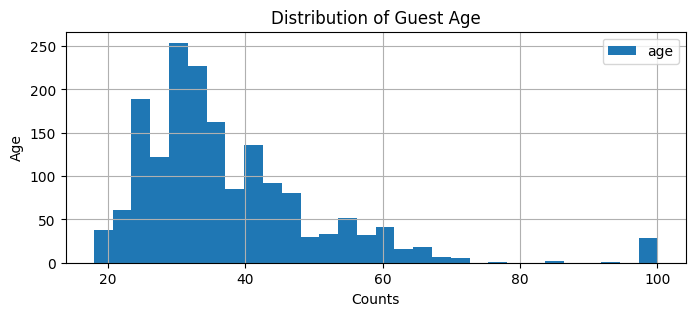

In [15]:
# Let's visualize age on a graph with clipping at 100
df.age.clip(upper=100).hist(bins=30, legend=True, figsize=(8,3))
plt.title('Distribution of Guest Age')
plt.xlabel('Counts')
plt.ylabel('Age')
plt.show();

In [16]:
# How many unique values per each variable? 
categorical_variables = ['destination','first_browser','language']
df[categorical_variables].nunique()

destination      11
first_browser    12
language         11
dtype: int64

Compared to the data, 11 to 12 unique values per each variable has moderate cardinality. One-hot encoding may not be the best procedure given that there would be 34 additional sparse columns added increasing overfitting. Though there are additional strategies such as data merging, or feature selection of one-hot encoded variable highly correlated with the booking variable, we will keep the MVP model simple by using ordinal encoding. This will represent each categorical value into a numeric value such that the classifer can be trained on the transformed data.

### Target Variable

In [17]:
# What's the percentage of booking?
print(f"Booking Proportion: {df['booking'].mean():0.3}")

Booking Proportion: 0.333


33% booking proportion shows that the target class is moderately imbalanced. This suggests that AUC may be the best evaluation metric when evaluating the performance of a classifier.

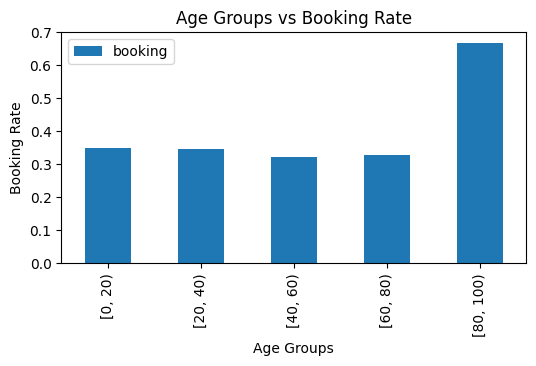

In [18]:
bins = [0, 20, 40, 60, 80, 100]
df['age_intervals'] = pd.cut(df['age'], bins, right=False)
df.groupby('age_intervals')['booking'].mean().plot.bar(legend=True, figsize=(6,3))
plt.title('Age Groups vs Booking Rate')
plt.xlabel('Age Groups')
plt.ylabel('Booking Rate')
plt.show();

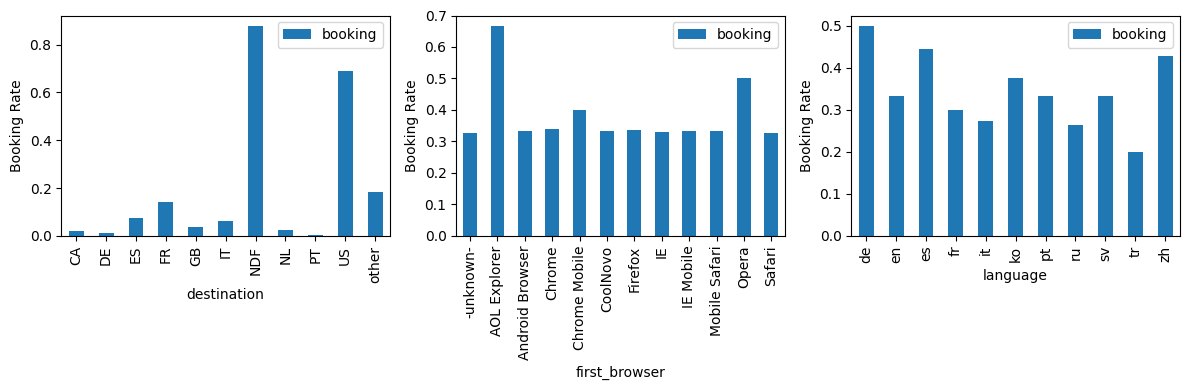

In [19]:
f, axes = plt.subplots(figsize=(12,4), ncols=3)
for i, c in enumerate(categorical_variables):
    df.groupby(c)['booking'].mean().plot.bar(legend=True, ax=axes[i])
    axes[i].set_ylabel('Booking Rate')
plt.tight_layout()
plt.show();

# Data Preprocessing

### Split data into train and test

In [20]:
# Apply 80-20 split on the train and test
features = ['age','destination','first_browser','language']
target = ['booking']
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=.2, random_state=SEED)

### Build a Column Transformer

In [21]:
# Let's construct a Column Transformer that applies different preprocessing techniques 
# to multiple feature columns in pipeline. We will apply mean-imputation on age and label
# encoding on categorical variables: ['destination','first_browser','language']
preprocess = ColumnTransformer([
  ('impute', SimpleImputer(strategy='mean'), ['age']),
  ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-99), ['destination', 'first_browser', 'language']),
], verbose_feature_names_out=False)

# Model Training

### Baseline Model

In [22]:
# Instantiate a model
rf_model = RandomForestClassifier(random_state=SEED)

# build a model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf_model', rf_model)
])

# Fit a model
model_pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('impute', SimpleImputer(),
                                                  ['age']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-99),
                                                  ['destination',
                                                   'first_browser',
                                                   'language'])],
                                   verbose_feature_names_out=False)),
                ('rf_model', RandomForestClassifier(random_state=123))])

In [23]:
# Evaluate baseline performance
y_pred = model_pipeline.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, y_pred)
print(f'AUC: {score:.3f}')

AUC: 0.913


### Hyper-Parameter Tuning with Grid Search

In [24]:
# Parameters for GridSearch model tuning
param_grid = {
    'rf_model__max_depth': range(3, 10, 1),
    'rf_model__n_estimators': range(20, 80, 10)
}

# Wrap the model evaluation function in a make_scorer builder
# This ensures that roc_auc_score is serializable when the model
# is persisted with Joblob.
def my_scorer(y_true, y_predicted):
    error = roc_auc_score(y_true, y_predicted)
    return error

my_func = make_scorer(my_scorer, greater_is_better=True)

# Use GridSearch to find the best parameters
grid_search = GridSearchCV(
    estimator=model_pipeline, 
    param_grid=param_grid, 
    scoring='roc_auc',
#     scoring=my_func, 
    n_jobs=-1, cv=5
)

grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('impute',
                                                                         SimpleImputer(),
                                                                         ['age']),
                                                                        ('ordinal_encoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-99),
                                                                         ['destination',
                                                                          'first_browser',
                                                                          'language'])],
                                                          verbose_feature_names_out=False)),
                                       ('rf_model',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'rf_model__max_depth': range(3, 10),
                         'rf_model__n_estimators': range(20, 80, 10)},
             scoring='roc_auc')

In [25]:
# Evaluate grid search model performance
y_pred = grid_search.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, y_pred)
print(f'AUC: {score:.3f}')

AUC: 0.929


# Export Model

In [26]:
file_name = "hotel_booking_model.joblib"
joblib.dump(grid_search, file_name)

['hotel_booking_model.joblib']

In [27]:
# Check that the model export worked
load_model = joblib.load(file_name)

# Ensure that the exported model is consistent when
# the model is loaded by comparing the evaluation scores.
y_pred = load_model.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, y_pred)
print(f'AUC: {score:.3f}')

AUC: 0.929
